# Entraînement avec Data augmentation

In [2]:
from bs4 import BeautifulSoup
import requests
import re
import unidecode
import time
import os
import json
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import nlpaug

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

# ---- first times : 
# nltk.download('wordnet')from sklearn.model_selection import GridSearchCV
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('stopwords')
# nltk.download('omw-1.4')

/home/erwan/projets/nlp/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Déclaration des fonctions

In [66]:
def replace_par_regex(tex:str, langue='francais') ->str :
    
    """
    mets les# liste2 = pd.DataFrame(liste)

# liste2.to_csv('dataaug.csv', index=False)it caractères en minuscule
    supprime les caractères non alphabétiques
    """

    # mettre le texte en minuscule
    pe = tex.lower()


    if langue == 'english':
        pe = re.sub('[^a-z_]','_',pe)
    else:
        pe = re.sub('[^a-zàâçéèêëîïôûùüÿñæœ]', '_', pe)
    
    # supprimer les mots de 1 ou deux lettres
    pe = re.sub('_[a-zàâçéèêëîïôûùüÿñæœ]{1,2}_', '_',pe)

    pe = re.sub('[_]{2,}','_',pe)
    pe = re.sub('_',' ',pe)
    
    # supprimer le l qui reste parfois
    pe = re.sub(' l ',' ', pe)

    return pe



def nbr_pages(u_r_l) -> int :  
    """
    trouve le nombre de pages à parser en fonction de l'indicatif des pages dans la première page html
    renvoie -1 en cas d'erreur    
    """

    soupObject = parse(u_r_l)
    
    # récupérer dans une liste les éléments de la calsse pagination-item-holer
    res = soupObject.find_all("div", class_="pagination-item-holder")

    # créer une chaîne de caractère à partir de la liste
    st = ""
    for el in res:
        st = st + (str(el))

    st = st.replace('>', '<')

    tab = st.split('<')

    ls = []
    for i in tab:

        try:
            ls.append(int(i))
        except:
            continue

    if len(ls) > 0:
        return max(ls)
    else:
       return 1



def afficher_nuage_mots(var:str, nombre_de_mots:int, langage='francais', *args):

    """
    affiche un nuage de mots les plus importants dans un texte
    prend en variables une chaîne de caractère, le nombre de mots importants à afficher, la langue, un tuple d'éventuels mots à ajouter au stopwords
    """


    if langage == 'english':
        SW = stopwords.words('english')
    else:
        SW = stopwords.words('french')
    

    if args:
        for el in args:
            SW.append(el)

    
    WC = WordCloud(background_color = 'white', stopwords = SW, max_words = nombre_de_mots).generate(var)
    plt.imshow(WC)
    plt.axis("off")
    plt.show()



def parse(u_r_l, html = True):

    """
    récupère le contenu d'une page html
    structure la réponse de requests
    transforme en objet avec ou sans le html
    retourne un objet Beautiful ou une chaîne de caractère    
    """

    # récupérer le contenu d'une page web
    page = requests.get(u_r_l)

    # structure la page
    soup = BeautifulSoup(page.content, 'html.parser')


    if html == False:
        soup = str(soup.get_text())
        
    
    return soup



def find_comment_and_rating(u_r_l):
    
    """
    trouver la division de la note, et retourner la note en float
    trouver la div du commentaire et retourner le commentaire
    """

    global dico

    # div de la note
    division_principale = 'hred review-card cf'
    division_note = "stareval-note"
    division_commentaire = "content-txt review-card-content"

    # récupérer la page internet
    soup = parse(u_r_l)
    foo = soup.find_all("div", class_= division_principale)

    title = soup.find('div', class_='titlebar titlebar-page')
    title = title.get_text()

    # récupérer la div des notes 

    dico = dict()
    

    for i in range(len(foo)):

        # parsage du parsage

        # --- la note
        ts = str(foo[i])
        fff = BeautifulSoup(ts, 'html.parser')
        ggg = fff.find('span', class_= division_note)

        # récupérer la note sans le html
        ggg  = ggg.get_text()
        ggg  = float(ggg.replace(',','.'))


        # --- le commentaire
        hhh = fff.find('div', class_= division_commentaire)
        hhh = hhh.get_text()
        hhh = replace_par_regex(hhh)

        dico[hhh] = ggg
       
    return dico, title



def recuperer_donnees_to_df(u_r_l):
    
    dci, title = find_comment_and_rating(u_r_l)
    nombre_de_pages_a_parser = nbr_pages(u_r_l)

    suffixe_url = '?page='

    url_complete = u_r_l + suffixe_url

    for i in range(2, nombre_de_pages_a_parser + 1):
        url = url_complete + str(i)
        
        try:
            data, _ = find_comment_and_rating(url)
            dci.update(data)
        except:
            continue

        time.sleep(0.2)


    # enregistrer le dictionnaire en csv ; le nom du csv est le timestamp

    ts = time.time()
    ts = str(int(ts))
    ts = ts + '.csv'
    title = title + '.csv'

    df = pd.DataFrame.from_dict(dci, orient='index')
    try:
        df.to_csv('./datas/'+title)
    except:
        df.to_csv('./datas/'+ts)


def clean_csv():

    """
    supprimer les fichiers csv du répertoire
    """

    for el in os.listdir():
        if 'csv' in el:
            os.remove(el)
  


def recupere_csv():
    
    """
    récupérer les fichiers csv créés
    """
    
    liste = []
    for fichier in (os.listdir('./data')):
        if 'csv' in fichier:

            adresse = os.path.join('data', fichier)
            
            liste.append(pd.read_csv(adresse))

    return liste, len(liste)


def lemm_stem(dataset, type='stem'):
    
    """
    lemmization ou stemming d'un dataset
    pour la lemmization, nécessité d'enlever les accents 
    retourne le dataset traité
    """



    french_stopwords = nltk.corpus.stopwords.words('french')
    lemmatizer = FrenchLefffLemmatizer()
    wnl = WordNetLemmatizer() 
    stemmer = SnowballStemmer(language='french')



    if type =='lemm':

        for i in range(dataset.shape[0]):

            st = ""    
            var = unidecode.unidecode(dataset.iloc[i, 0])
            tokenize_sentence = nltk.tokenize.word_tokenize(var)   
            words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]    
            words_lemmatize = [wnl.lemmatize(w) for w in words_w_stopwords] 
            for j in range(len(words_lemmatize)):
                st = st + ' ' + words_lemmatize[j] + ' '
            dataset.iloc[i,0] = st
        
        return dataset


    if type =='stem':

        for i in range(dataset.shape[0]):

            st = ""
            tokenize_sentence = nltk.tokenize.word_tokenize(dataset.iloc[i, 0])
            words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]
            words_stemming = [stemmer.stem(w) for w in words_w_stopwords]
            for j in range(len(words_stemming)):
                st = st + ' ' + words_stemming[j] + ' '
            dataset.iloc[i, 0] = st

        return dataset


def sac_de_mots(dataframe, sac):
    
    """
    ne garder que les mots du sacs de mots
    """

    for i in range(dataframe.shape[0]):


        liste = np.array(dataframe.iloc[i].split(' '))
        bag = np.array(sac)

        res = np.intersect1d(bag, liste) 
    
        stri = ""

        for occ in list(res):

            stri = stri + ' ' + occ

        dataframe.iloc[i] = stri



def intersection(datafram, sac):

    
    dataframe = datafram.copy()
    for i in range(dataframe.shape[0]):
    # for i in range(10):

        phra = np.array(dataframe.iloc[i, 0].split())

        phra = np.intersect1d(phra, sac)
    
        st = ""
        for j in range(phra.shape[0]):
            st = st + " " + phra[j]

        dataframe.iloc[i, 0] = st 

    return dataframe

## Charger les csv préparés auparavant avec les commentaires et la data-augmentation   

> dans le fichier train.ipynb

In [11]:
data1 = pd.read_csv('data_total.csv')
data1 = data1.rename(columns={data1.columns[0]:'commentaire', data1.columns[1]:'note'})
data2 = pd.read_csv('dataaug2.csv')

In [19]:
data = pd.concat((data1, data2), ignore_index=True)

In [32]:
df = data.copy()

#### préparer les labels

In [33]:
for i in range(df.shape[0]):
    
    if df.loc[i, 'note'] > 2.5:
        df.loc[i, 'note'] = 1
    else:
        df.loc[i, 'note'] = 0


In [34]:
df['note'].value_counts()

1.0    34141
0.0    25523
Name: note, dtype: int64

> il y a toujours plus de notes positives, on équilibre

In [39]:
df_good = df[df['note'] == 1].iloc[:25523, :]
df_bad = df[df['note'] == 0]

In [40]:
df = pd.concat((df_good, df_bad), ignore_index=True)

<AxesSubplot:ylabel='note'>

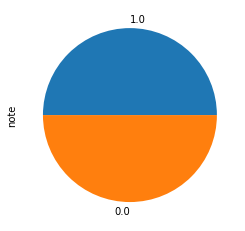

In [43]:
df['note'].value_counts().plot.pie()

## Séparation du jeu de données et réduction de dimensions

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df['commentaire'], df['note'], random_state=3, stratify=df['note'])

In [48]:
da1 = X_train.copy()
da1 = X_train.reset_index(drop=True)
da2 = y_train.copy()
da2 = y_train.reset_index(drop=True)
da1 = pd.DataFrame(da1)
da1['note'] = da2

df_bad = da1[da1['note']==0]
df_good = da1[da1['note']==1]

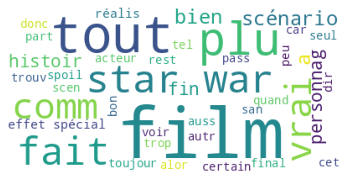

In [53]:
st_bad = ""

for i in range(df_bad.shape[0]):

    st_bad = st_bad + " " + df_bad.iloc[i, 0] + " "


afficher_nuage_mots(st_bad, nombre_de_mots=40)

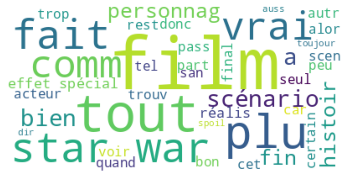

In [54]:
st_good = ""

for i in range(df_good.shape[0]):

    st_good = st_bad + " " + df_good.iloc[i, 0] + " "


afficher_nuage_mots(st_good, nombre_de_mots=40)

In [56]:
nombre_mots2 = 500

sac_de_mots_bad = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots2).generate(st_bad).words_
sac_de_mots_good = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots2).generate(st_good).words_
#
#  transformer les mots (clé du dictionnaire) en listes
sac_de_mots_bad = list(sac_de_mots_bad.keys())
sac_de_mots_good =  list(sac_de_mots_good.keys())

sac_de_mots_good.remove('film')
sac_de_mots_bad.remove('film')

In [68]:
df_bad = intersection(df_bad, sac_de_mots_bad)
df_good = intersection(df_good, sac_de_mots_good)

## Entraînement du modèle

In [72]:
X_train = pd.concat((df_bad, df_good), ignore_index=True)
X_train = X_train.sample(frac=1).reset_index(drop=True)

y_train = X_train.drop('commentaire', axis=1)
X_train = X_train['commentaire']

In [75]:
cvec = CountVectorizer()

In [76]:
cvec.fit(np.intersect1d(sac_de_mots_good, sac_de_mots_bad))

CountVectorizer()

In [77]:
X_train = pd.DataFrame(cvec.transform(X_train).todense().tolist())
X_test = pd.DataFrame(cvec.transform(X_test).todense().tolist())

In [84]:
param = {
    'max_iter' : [1000, 10000], 
    'C' : [0.1, 0.4, 0.7],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'warm_start' : [True, False]
}


model = GridSearchCV(LogisticRegression(), param_grid=param, cv=5)


model.fit(X_train, np.array(y_train).ravel()) 
score_train = model.best_score_
score_test = model.score(X_test, np.array(y_test).ravel())


In [81]:
print(f'{score_train:-<30} score sur les données d\'entraînement')
print(f'{score_test:-<30} score sur les données de test')

0.8389405975832414------------ score sur les données d'entraînement
0.8167215170036044------------ score sur les données de test


In [82]:
model.best_params_

{'C': 0.7, 'max_iter': 1000, 'penalty': 'l2', 'warm_start': True}

In [83]:
model.best_score_

0.8389405975832414